In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from transformers import set_seed

# =========================
# Config
# =========================
SEED = 42
set_seed(SEED)
HF_MODEL = "csebuetnlp/banglabert"   # ✅ BanglaBERT
MAX_LEN = 128
EPOCHS = 5
LR = 3e-5
BATCH = 16
VAL_SPLIT = 0.2

# =========================
# Load Dataset
# =========================
df = pd.read_excel("traindataset.xlsx")   # <-- replace with your dataset file
df = df[["Questions", "Genarated_Answer", "label"]].dropna()

# Combine Q + A as input
df["input_text"] = df["Questions"].astype(str) + " " + df["Genarated_Answer"].astype(str)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["input_text"], df["label"], test_size=VAL_SPLIT, stratify=df["label"], random_state=SEED
)

# =========================
# Tokenization
# =========================
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset   = Dataset.from_dict({"text": val_texts.tolist(),   "label": val_labels.tolist()})

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)

# =========================
# Handle Class Imbalance
# =========================
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.array([0, 1]),
    y=df["label"].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# =========================
# Model & Trainer
# =========================
model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL, num_labels=2)

training_args = TrainingArguments(
    output_dir="saved_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    num_train_epochs=EPOCHS,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir="./logs",
    logging_steps=10,
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# =========================
# Train Model
# =========================
trainer.train()
trainer.save_model("saved_model")
tokenizer.save_pretrained("saved_model")



Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\robiu\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.652200,0.616931
2,0.450500,0.484801
3,0.239000,0.539414
4,0.169600,0.616890
5,0.110300,0.619156


c:\Users\robiu\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\robiu\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\robiu\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\robiu\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warn

('saved_model\\tokenizer_config.json',
 'saved_model\\special_tokens_map.json',
 'saved_model\\vocab.txt',
 'saved_model\\added_tokens.json',
 'saved_model\\tokenizer.json')

c:\Users\robiu\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


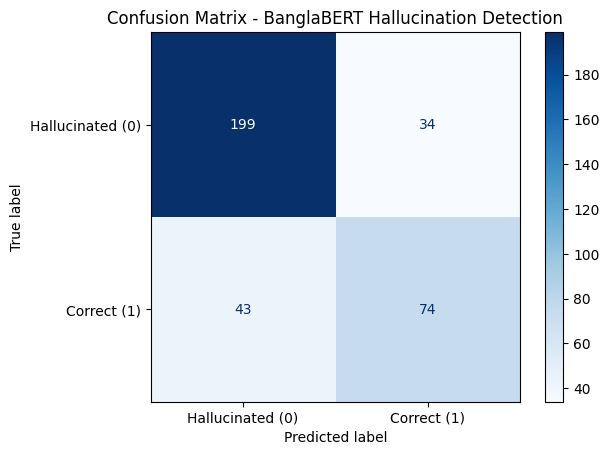

In [4]:
# ======================
# 1️⃣1️⃣  Confusion Matrix
# ======================
preds = trainer.predict(val_dataset)
y_true = val_labels.values
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hallucinated (0)", "Correct (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - BanglaBERT Hallucination Detection")
plt.show()